In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

% matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


In [2]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [3]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [4]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [5]:
from funcs_var import *

---

### Data Collection

#### short term interest rate

In [6]:
stir = pd.read_csv('var/short_term_int_rate_m.csv')

In [7]:
stir = stir[['TIME', 'Value']].copy()

#### inflation rate

In [8]:
ir_ = pd.read_csv('var/inflation_rate_m.csv')

In [9]:
ir = []
for i in range(len(ir_.iloc[:, 1:13])):
    ir = ir + ir_.iloc[i, 1:13].tolist()

In [10]:
ir = ir[:-9]

In [11]:
ir = [float(ir[i]) for i in range(len(ir))]

In [12]:
ir_dt = []
for i in range(len(ir)):
    y = (datetime.strptime('1914-01', '%Y-%M') + relativedelta(months=i)).year
    m = (datetime.strptime('1914-01', '%Y-%M') + relativedelta(months=i)).month
    ir_dt.append(str(y)+'-'+str(m))

In [13]:
ir = pd.DataFrame([ir_dt, ir], index=['TIME', 'Value']).T

#### unemployment rate

In [14]:
ur = pd.read_csv('var/unemployment_rate_m.csv')

In [15]:
ur = ur[['TIME', 'Value']].copy()

#### Make full df

In [16]:
ur[ur['TIME']=='1964-06']

,TIME,Value
113,1964-06,5.2


In [17]:
ir[ir['TIME']=='1964-6']

,TIME,Value
605,1964-6,1.3


In [18]:
stir.head()

,TIME,Value
0,1964-06,3.86
1,1964-07,3.87
2,1964-08,3.85
3,1964-09,3.87
4,1964-10,3.94


In [19]:
df_var = pd.concat([stir, 
           pd.DataFrame(ir.iloc[605:, 1]).reset_index(drop=True), 
           pd.DataFrame(ur.iloc[113:, 1]).reset_index(drop=True)], 
          axis=1)
df_var.columns = ['TIME','stir', 'infr', 'umpr']

---

### Stationarity part

In [20]:
df_var.head()

,TIME,stir,infr,umpr
0,1964-06,3.86,1.3,5.2
1,1964-07,3.87,1.3,4.9
2,1964-08,3.85,1,5.0
3,1964-09,3.87,1.3,5.1
4,1964-10,3.94,1,5.1


In [21]:
df_var = df_var.iloc[:-5, :].copy()

In [22]:
df_var_t = df_var.copy()
df_var_t['TIME'] = pd.to_datetime(df_var_t['TIME'])
df_var_t.index = df_var_t['TIME']

Results of Dickey-Fuller Test:
Test Statistic                  -2.169757
p-value                          0.217404
#Lags Used                      19.000000
Number of Observations Used    609.000000
Critical Value (5%)             -2.866298
Critical Value (1%)             -3.441133
Critical Value (10%)            -2.569304
dtype: float64


Results of KPSS Test:
Test Statistic            1.542907
p-value                   0.010000
#Lags Used               20.000000
Critical Value (2.5%)     0.574000
Critical Value (5%)       0.463000
Critical Value (1%)       0.739000
Critical Value (10%)      0.347000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


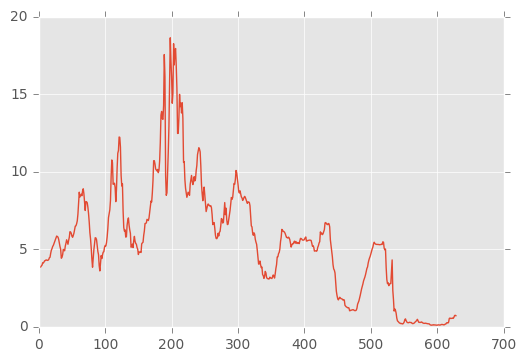

In [23]:
test_stationarity(df_var_t['stir'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.026327
p-value                          0.032508
#Lags Used                      18.000000
Number of Observations Used    610.000000
Critical Value (5%)             -2.866290
Critical Value (1%)             -3.441116
Critical Value (10%)            -2.569300
dtype: float64


Results of KPSS Test:
Test Statistic            1.154627
p-value                   0.010000
#Lags Used               20.000000
Critical Value (2.5%)     0.574000
Critical Value (5%)       0.463000
Critical Value (1%)       0.739000
Critical Value (10%)      0.347000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


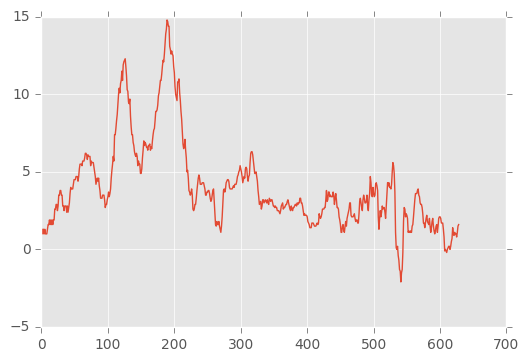

In [24]:
test_stationarity(df_var_t['infr'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.355673
p-value                          0.012566
#Lags Used                       6.000000
Number of Observations Used    622.000000
Critical Value (5%)             -2.866198
Critical Value (1%)             -3.440907
Critical Value (10%)            -2.569251
dtype: float64


Results of KPSS Test:
Test Statistic            0.24785
p-value                   0.10000
#Lags Used               20.00000
Critical Value (2.5%)     0.57400
Critical Value (5%)       0.46300
Critical Value (1%)       0.73900
Critical Value (10%)      0.34700
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


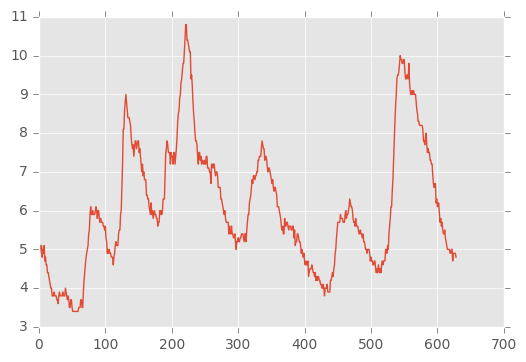

In [25]:
test_stationarity(df_var_t['umpr'])

In [26]:
df_var_1982 = df_var.iloc[215:, :].copy().reset_index(drop=True)

In [27]:
df_var_1982_t = df_var_1982.copy()
df_var_1982_t.index = df_var_1982_t['TIME']

In [28]:
df_var_1982.head()

,TIME,stir,infr,umpr
0,1982-05,13.80,6.7,9.4
1,1982-06,14.46,7.1,9.6
2,1982-07,13.44,6.4,9.8
3,1982-08,10.61,5.9,9.8
4,1982-09,10.66,5,10.1


Results of Dickey-Fuller Test:
Test Statistic                  -3.151226
p-value                          0.022987
#Lags Used                       1.000000
Number of Observations Used    412.000000
Critical Value (5%)             -2.868581
Critical Value (1%)             -3.446322
Critical Value (10%)            -2.570521
dtype: float64


Results of KPSS Test:
Test Statistic            1.82166
p-value                   0.01000
#Lags Used               18.00000
Critical Value (2.5%)     0.57400
Critical Value (5%)       0.46300
Critical Value (1%)       0.73900
Critical Value (10%)      0.34700
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


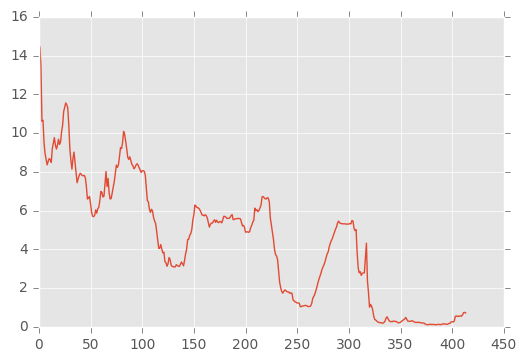

In [29]:
test_stationarity(df_var_1982['stir'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.464694
p-value                          0.124303
#Lags Used                      15.000000
Number of Observations Used    398.000000
Critical Value (5%)             -2.868829
Critical Value (1%)             -3.446888
Critical Value (10%)            -2.570653
dtype: float64


Results of KPSS Test:
Test Statistic            1.179575
p-value                   0.010000
#Lags Used               18.000000
Critical Value (2.5%)     0.574000
Critical Value (5%)       0.463000
Critical Value (1%)       0.739000
Critical Value (10%)      0.347000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


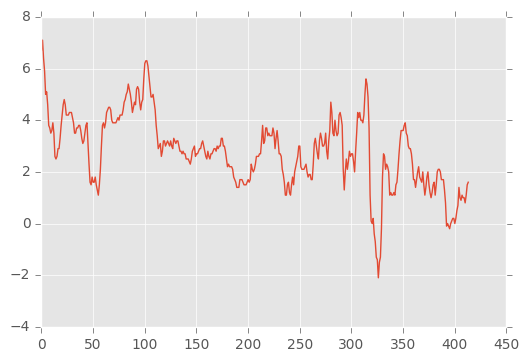

In [30]:
test_stationarity(df_var_1982['infr'])

Results of Dickey-Fuller Test:
Test Statistic                  -4.220701
p-value                          0.000608
#Lags Used                       6.000000
Number of Observations Used    407.000000
Critical Value (5%)             -2.868668
Critical Value (1%)             -3.446520
Critical Value (10%)            -2.570567
dtype: float64


Results of KPSS Test:
Test Statistic            0.267736
p-value                   0.100000
#Lags Used               18.000000
Critical Value (2.5%)     0.574000
Critical Value (5%)       0.463000
Critical Value (1%)       0.739000
Critical Value (10%)      0.347000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


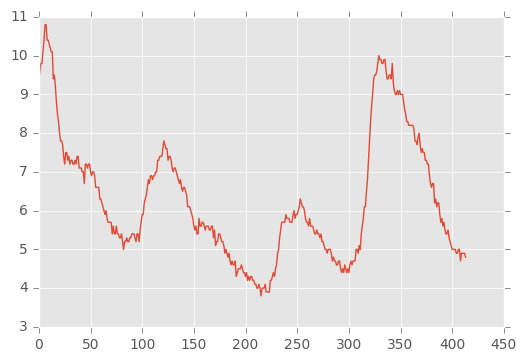

In [31]:
test_stationarity(df_var_1982['umpr'])

## Forecasting

#### 6 steps

In [32]:
train = df_var_t.iloc[:-6, 1:]
test = df_var_t.iloc[-6:, 1:]

In [33]:
LAG = 4

In [34]:
STEPS = 6

### VAR

In [38]:
def var_model(train, steps, lags, years=None):
    df = np.array(train)
    years_out=None
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(1, steps+1)]
    model = VAR(df)
    fitm = model.fit(maxlags=lags)
    var_in = pd.DataFrame(fitm.fittedvalues, 
                          columns=train.columns, 
                          index=years)
    var_out = fitm.forecast(y=df, steps=steps)
    var_out = pd.DataFrame(var_out, 
                           columns=train.columns, 
                           index=years_out)
    return {'in':var_in, 'out':var_out}

In [39]:
#years=train['TIME'][2:-6].reset_index(drop=True)
var_result = var_model(train, steps=STEPS, lags=LAG, years=train.index[LAG:])

In [40]:
print(error(var_result['out']['stir'], test['stir']))
print(error(var_result['out']['infr'], test['infr']))
print(error(var_result['out']['umpr'], test['umpr']))

{'rmse': 0.13520855347785773, 'mse': 0.018281352933574718, 'mae': 0.1197546199342072}
{'rmse': 0.28136105876616235, 'mse': 0.079164045390015869, 'mae': 0.24896489625364449}
{'rmse': 0.1416345374865603, 'mse': 0.020060342209031856, 'mae': 0.10971571578026795}


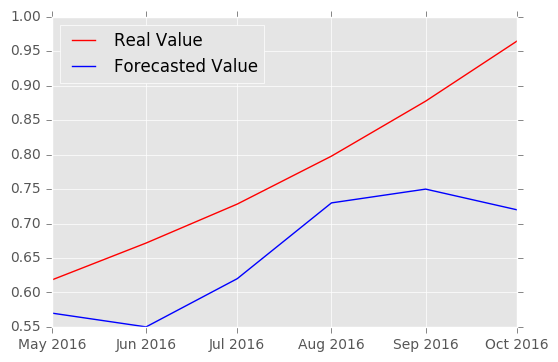

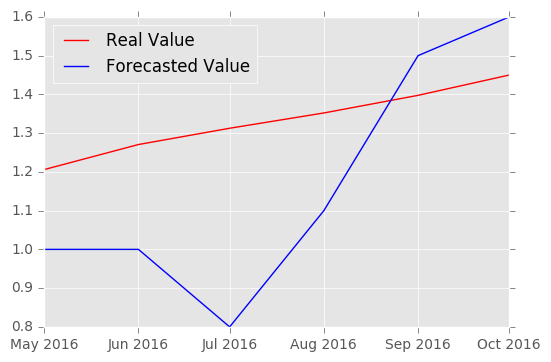

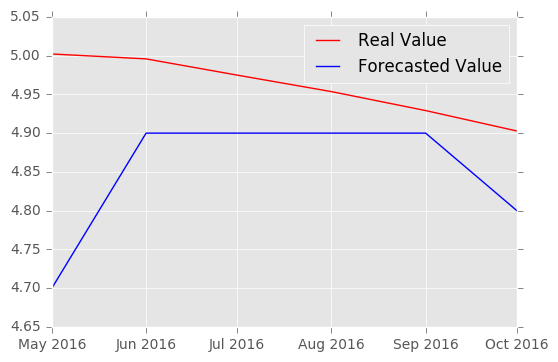

In [41]:
plot_compar(var_result['out']['stir'], test['stir'])
plot_compar(var_result['out']['infr'], test['infr'])
plot_compar(var_result['out']['umpr'], test['umpr'])

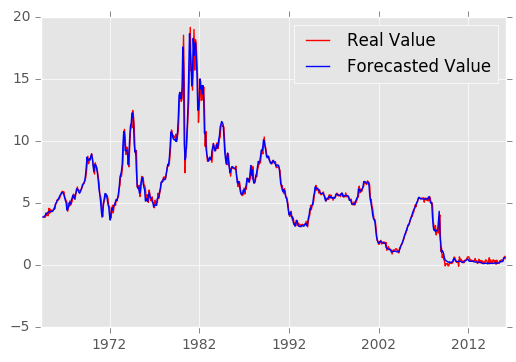

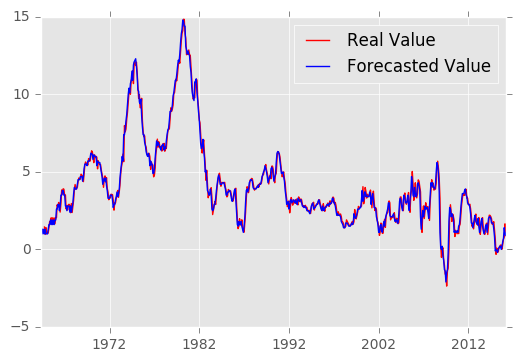

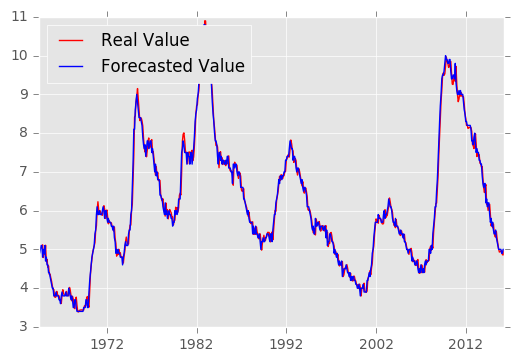

In [42]:
plot_compar(var_result['in']['stir'], train['stir'])
plot_compar(var_result['in']['infr'], train['infr'])
plot_compar(var_result['in']['umpr'], train['umpr'])

### ANN

In [43]:
df_nn = nn_transform(train, n=LAG)

In [44]:
train_nn_x = df_nn.iloc[:, 3:].copy()
train_nn_y = df_nn.iloc[:, :3].copy()

Первый запуск модели для проверки ее устойчивости

In [45]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [46]:
def nn_model(x, y, n_feat, lag, steps, model, years=None, epoch=100):
    years_out=None
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(1, steps+1)]
    model.fit(np.array(x), np.array(y),
       nb_epoch=epoch, 
       verbose=2,
       batch_size=1)
    nn_in = pd.DataFrame(model.predict(np.array(x)), 
                         columns=y.columns, 
                         index=years)
    nn_out = nn_predict(model, train, lags=lag, steps=steps)
    if years is not None:
        nn_out.index = years_out
    return {'in':nn_in, 'out':nn_out}

In [47]:
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=6, model=nn, 
                     years=train_nn_y.index, 
                     epoch=100)

Epoch 1/100
0s - loss: 18.7992
Epoch 2/100
0s - loss: 7.4889
Epoch 3/100
0s - loss: 5.9130
Epoch 4/100
0s - loss: 5.0690
Epoch 5/100
0s - loss: 4.3555
Epoch 6/100
0s - loss: 3.8226
Epoch 7/100
0s - loss: 3.4104
Epoch 8/100
0s - loss: 3.1011
Epoch 9/100
0s - loss: 2.8675
Epoch 10/100
0s - loss: 2.6733
Epoch 11/100
0s - loss: 2.4878
Epoch 12/100
0s - loss: 2.3206
Epoch 13/100
0s - loss: 2.1742
Epoch 14/100
0s - loss: 2.0214
Epoch 15/100
0s - loss: 1.8944
Epoch 16/100
0s - loss: 1.7636
Epoch 17/100
0s - loss: 1.6577
Epoch 18/100
0s - loss: 1.5629
Epoch 19/100
0s - loss: 1.4369
Epoch 20/100
0s - loss: 1.3424
Epoch 21/100
0s - loss: 1.2860
Epoch 22/100
0s - loss: 1.1900
Epoch 23/100
0s - loss: 1.1147
Epoch 24/100
0s - loss: 1.0546
Epoch 25/100
0s - loss: 0.9839
Epoch 26/100
0s - loss: 0.9264
Epoch 27/100
0s - loss: 0.8796
Epoch 28/100
0s - loss: 0.8159
Epoch 29/100
0s - loss: 0.7594
Epoch 30/100
0s - loss: 0.7165
Epoch 31/100
0s - loss: 0.6596
Epoch 32/100
0s - loss: 0.6256
Epoch 33/100
0s 

In [49]:
print(error(nn_result['out']['stir'], test['stir']))
print(error(nn_result['out']['infr'], test['infr']))
print(error(nn_result['out']['umpr'], test['umpr']))

{'rmse': 0.34376341170854041, 'mse': 0.11817328322949545, 'mae': 0.29048812588055928}
{'rmse': 0.44756944593388182, 'mse': 0.20031840893356198, 'mae': 0.42158587773640943}
{'rmse': 0.9517881644326297, 'mse': 0.9059007099540346, 'mae': 0.90750136375427226}


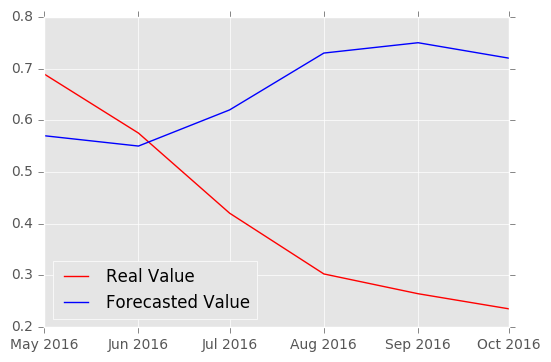

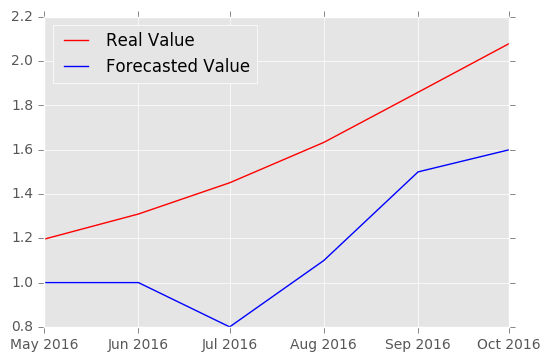

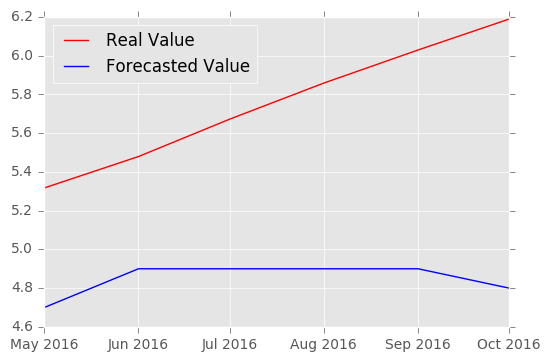

In [50]:
plot_compar(nn_result['out']['stir'], test['stir'])
plot_compar(nn_result['out']['infr'], test['infr'])
plot_compar(nn_result['out']['umpr'], test['umpr'])

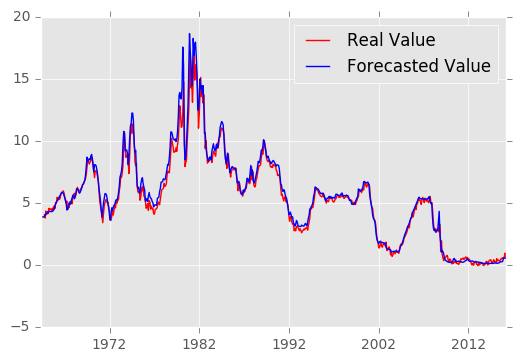

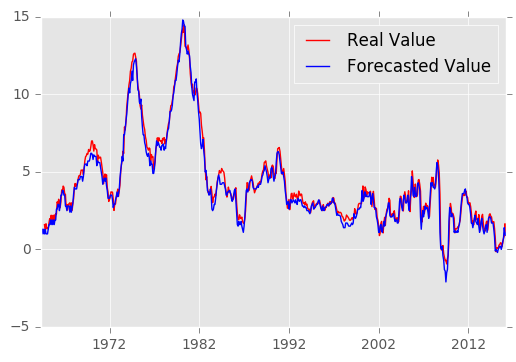

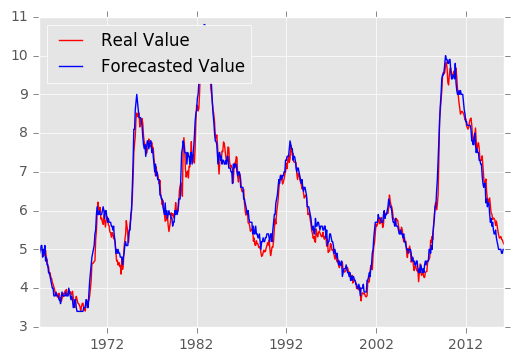

In [51]:
plot_compar(nn_result['in']['stir'], train['stir'])
plot_compar(nn_result['in']['infr'], train['infr'])
plot_compar(nn_result['in']['umpr'], train['umpr'])

Второй запуск модели

In [54]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [55]:
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=6, model=nn, 
                     years=train_nn_y.index, 
                     epoch=150)

Epoch 1/150
0s - loss: 18.3509
Epoch 2/150
0s - loss: 8.3058
Epoch 3/150
0s - loss: 6.2154
Epoch 4/150
0s - loss: 4.9452
Epoch 5/150
0s - loss: 4.1676
Epoch 6/150
0s - loss: 3.6436
Epoch 7/150
0s - loss: 3.2570
Epoch 8/150
0s - loss: 2.9881
Epoch 9/150
0s - loss: 2.7491
Epoch 10/150
0s - loss: 2.5460
Epoch 11/150
0s - loss: 2.3773
Epoch 12/150
0s - loss: 2.2087
Epoch 13/150
0s - loss: 2.0203
Epoch 14/150
0s - loss: 1.8559
Epoch 15/150
0s - loss: 1.6831
Epoch 16/150
0s - loss: 1.5216
Epoch 17/150
0s - loss: 1.3723
Epoch 18/150
0s - loss: 1.2357
Epoch 19/150
0s - loss: 1.1316
Epoch 20/150
0s - loss: 1.0094
Epoch 21/150
0s - loss: 0.9351
Epoch 22/150
0s - loss: 0.8631
Epoch 23/150
0s - loss: 0.7866
Epoch 24/150
0s - loss: 0.7392
Epoch 25/150
0s - loss: 0.6943
Epoch 26/150
0s - loss: 0.6232
Epoch 27/150
0s - loss: 0.5921
Epoch 28/150
0s - loss: 0.5760
Epoch 29/150
0s - loss: 0.5470
Epoch 30/150
0s - loss: 0.5320
Epoch 31/150
0s - loss: 0.4733
Epoch 32/150
0s - loss: 0.4705
Epoch 33/150
0s 

In [56]:
print(error(nn_result['out']['stir'], test['stir']))
print(error(nn_result['out']['infr'], test['infr']))
print(error(nn_result['out']['umpr'], test['umpr']))

{'rmse': 0.70494874522565931, 'mse': 0.49695273339523155, 'mae': 0.58232048193613684}
{'rmse': 1.3156786034054746, 'mse': 1.7310101874589801, 'mae': 0.97503185272216797}
{'rmse': 0.98987277987506117, 'mse': 0.97984812033758129, 'mae': 0.91854856808980279}


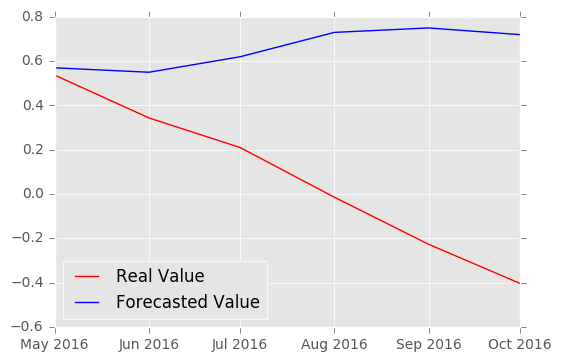

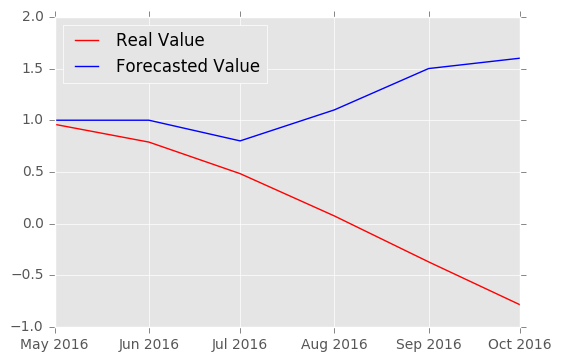

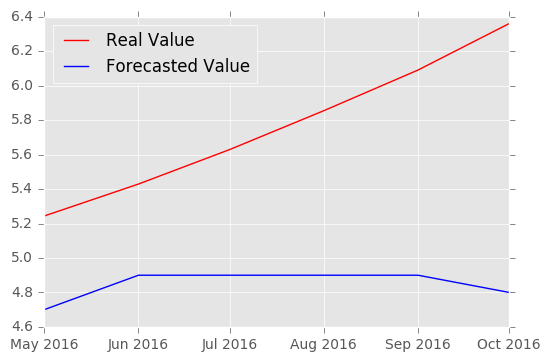

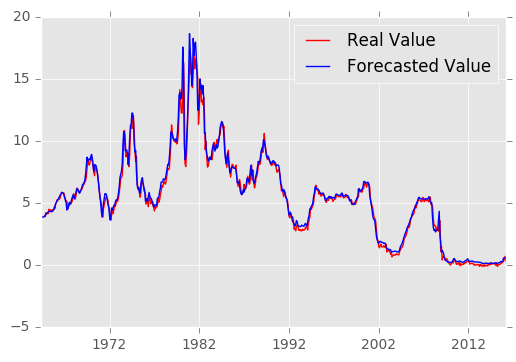

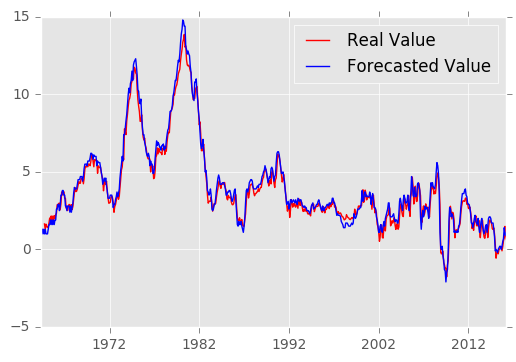

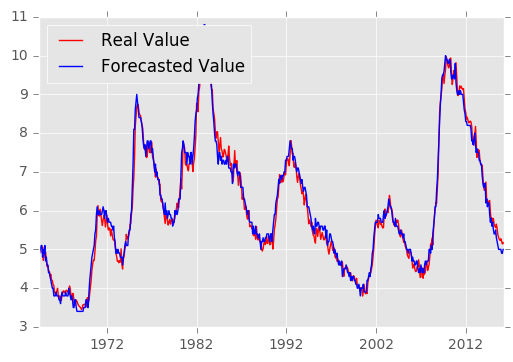

In [57]:
plot_compar(nn_result['out']['stir'], test['stir'])
plot_compar(nn_result['out']['infr'], test['infr'])
plot_compar(nn_result['out']['umpr'], test['umpr'])
plot_compar(nn_result['in']['stir'], train['stir'])
plot_compar(nn_result['in']['infr'], train['infr'])
plot_compar(nn_result['in']['umpr'], train['umpr'])

### Hybrid

In [70]:
def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    
    resid_df = pd.DataFrame(fitm.resid)
    resid_df.columns = train.columns
    
    df_nn = nn_transform(resid_df, n=lags)
    train_nn_x = df_nn.iloc[:, n_feat:].copy()
    train_nn_y = df_nn.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    
    hybrid_result = pd.DataFrame(var_result + nn_result.as_matrix())
    hybrid_result.columns = train.columns
    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(1, steps+1)]
        hybrid_result.index = ind
    return hybrid_result

In [71]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [72]:
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=10)

Epoch 1/10
1s - loss: 0.2475
Epoch 2/10
0s - loss: 0.1365
Epoch 3/10
0s - loss: 0.1364
Epoch 4/10
0s - loss: 0.1358
Epoch 5/10
0s - loss: 0.1344
Epoch 6/10
0s - loss: 0.1353
Epoch 7/10
0s - loss: 0.1360
Epoch 8/10
0s - loss: 0.1349
Epoch 9/10
0s - loss: 0.1352
Epoch 10/10
0s - loss: 0.1345
2016-04


Первый запуск

In [73]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))

{'rmse': 0.10359557508650942, 'mse': 0.01073204317750461, 'mae': 0.084656749003881523}
{'rmse': 0.25354369243582292, 'mse': 0.064284403973991155, 'mae': 0.23327078218450056}
{'rmse': 0.14791660611047877, 'mse': 0.021879322363242526, 'mae': 0.11742910319011395}


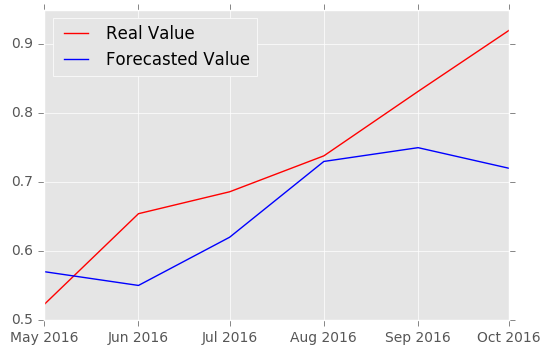

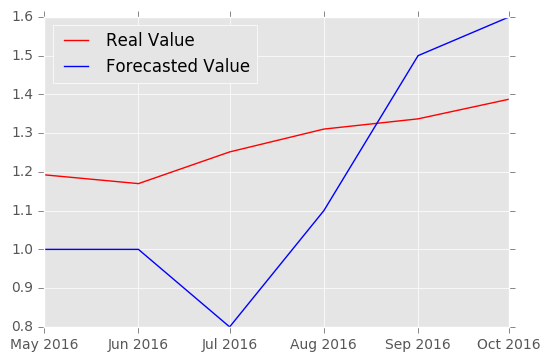

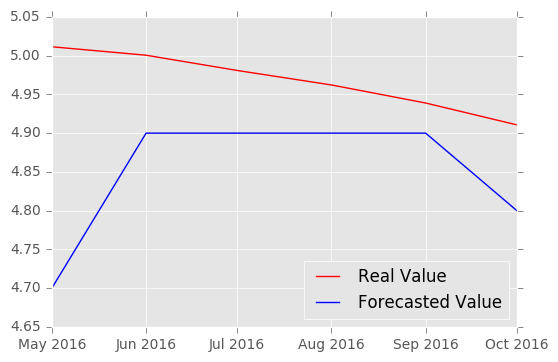

In [74]:
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

Второй запуск

In [75]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=6, model_nn=nn, years=True, epoch=10)

Epoch 1/10
0s - loss: 0.2181
Epoch 2/10
0s - loss: 0.1364
Epoch 3/10
0s - loss: 0.1363
Epoch 4/10
0s - loss: 0.1365
Epoch 5/10
0s - loss: 0.1363
Epoch 6/10
0s - loss: 0.1358
Epoch 7/10
0s - loss: 0.1347
Epoch 8/10
0s - loss: 0.1360
Epoch 9/10
0s - loss: 0.1354
Epoch 10/10
0s - loss: 0.1353
2016-04


In [76]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))

{'rmse': 0.13698056232362527, 'mse': 0.018763674454496587, 'mae': 0.11802775602841974}
{'rmse': 0.31964625718517309, 'mse': 0.10217372973248982, 'mae': 0.26985599890539952}
{'rmse': 0.15778198255526599, 'mse': 0.024895154019070258, 'mae': 0.12994180195968333}


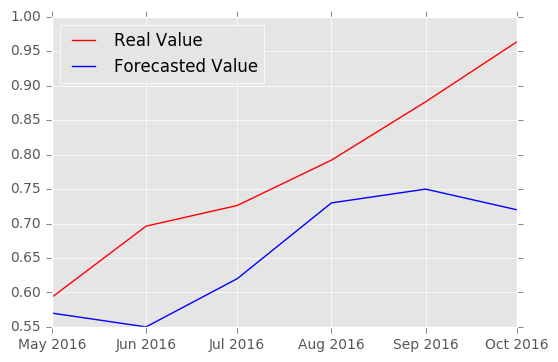

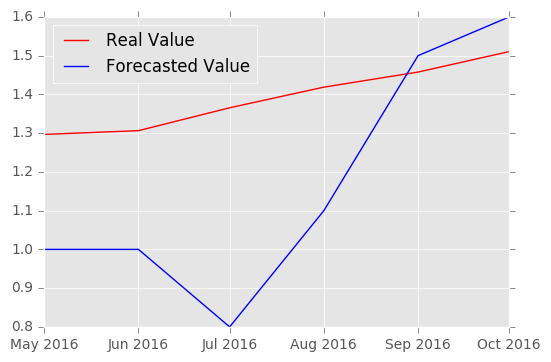

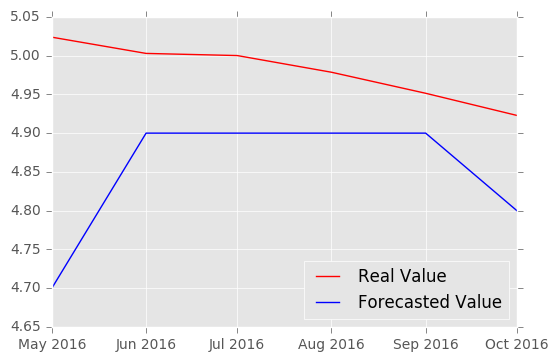

In [77]:
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

С DropOut

In [78]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=6, model_nn=nn, years=True, epoch=10)

Epoch 1/10
1s - loss: 0.3467
Epoch 2/10
0s - loss: 0.1905
Epoch 3/10
0s - loss: 0.1540
Epoch 4/10
0s - loss: 0.1429
Epoch 5/10
0s - loss: 0.1418
Epoch 6/10
0s - loss: 0.1405
Epoch 7/10
0s - loss: 0.1377
Epoch 8/10
0s - loss: 0.1377
Epoch 9/10
0s - loss: 0.1371
Epoch 10/10
0s - loss: 0.1364
2016-04


In [79]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))

{'rmse': 0.12668558462024249, 'mse': 0.016049237350572617, 'mae': 0.10988852820102969}
{'rmse': 0.28371027219619266, 'mse': 0.080491518549637722, 'mae': 0.25025052269022818}
{'rmse': 0.15413835678697377, 'mse': 0.023758633032988422, 'mae': 0.12537993656785273}


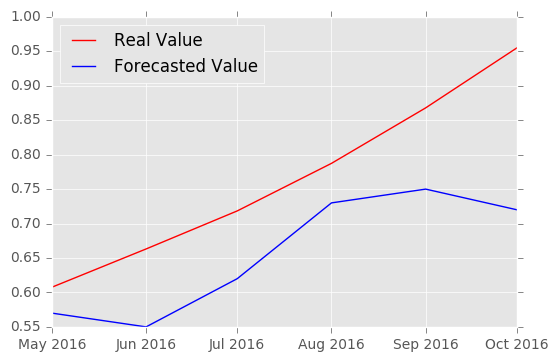

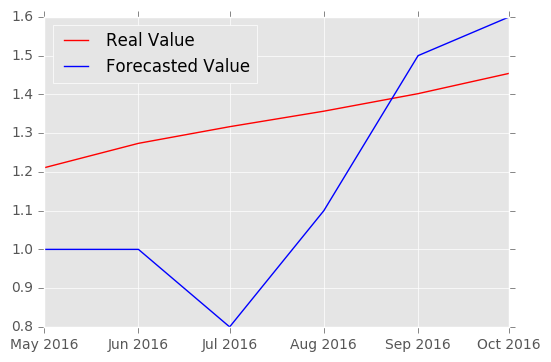

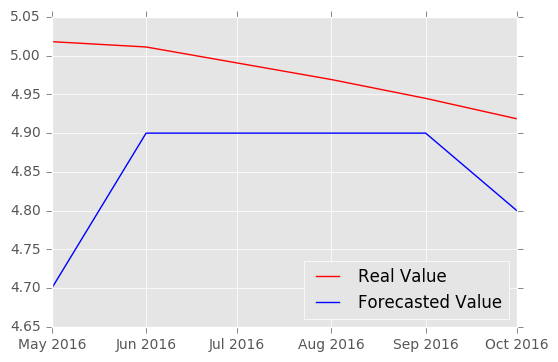

In [80]:
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])